# Simple regression

In [1]:
import jax
import jax.numpy as jnp
from pcv.inference import run_cv_sel, full_data_warmup, cv_warmup
from pcv.plots import plot_model_results, plot_fold_results
from pcv.models import reg
from pcv.rules import make_positive_rule, make_positive_negative_rule
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Model definition

Gaussian linear regression, with an outlier injected into the data

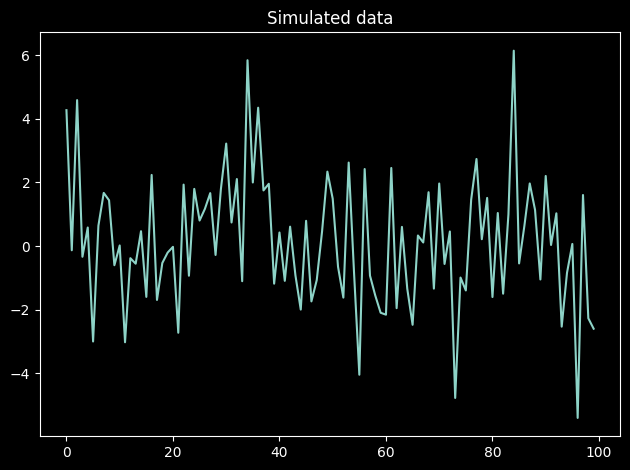

In [2]:
y, X = reg.generate(
    key=jax.random.PRNGKey(0),
    N = 100,
    beta0 = jnp.array([1.0, 1.0, 1.0, 0.5]),
    sigsq0 = jnp.array(2.0))

plt.plot(y)
plt.title('Simulated data')
plt.tight_layout()

In [3]:
K = 10
logjoint_density, log_pred, make_initial_pos = reg.get_model(y, X, K=K)

In [4]:
state, params = full_data_warmup(
    prng_key=jax.random.PRNGKey(0),
    logjoint_density=logjoint_density,
    make_initial_pos=make_initial_pos,
    num_chains=32,
    batch_size=100,
    warmup_iter=10000,
    model_id=0,
    prior_only=False
)

MEADS warmup for model (32 chains)...
MEADS warmup took 4.80 seconds


In [11]:
params

{'step_size': Array(0.5497808, dtype=float32),
 'momentum_inverse_scale': Theta(beta=Array([0.08882144, 0.13179824, 0.10447998, 0.14368422], dtype=float32), sigsq=Array(0.13469891, dtype=float32)),
 'alpha': Array(0.67327094, dtype=float32),
 'delta': Array(0.33663547, dtype=float32)}

## CV


In [8]:
state, params = cv_warmup(
    prng_key=jax.random.PRNGKey(0),
    logjoint_density=logjoint_density,
    make_initial_pos=make_initial_pos,
    num_folds=K,
    num_chains=32,
    batch_size=100,
    warmup_iter=10000
)

MEADS warmup for 10 folds per model (640 chains)...
MEADS warmup took 9.28 seconds


In [11]:
params.keys()

dict_keys(['alpha', 'delta', 'momentum_inverse_scale', 'step_size'])

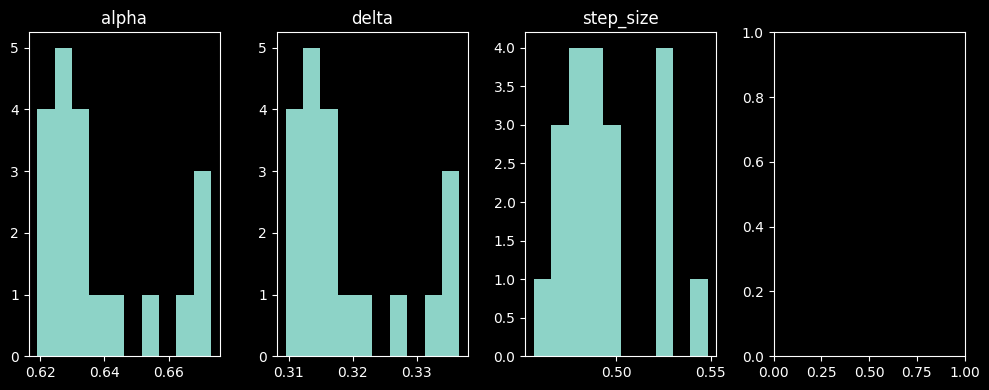

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))
p_al, p_del, p_step, p_momentum = axes
p_al.hist(params['alpha'])
p_al.set_title('alpha')
p_del.hist(params['delta'])
p_del.set_title('delta')
p_step.hist(params['step_size'])
p_step.set_title('step_size')
fig.tight_layout()

In [3]:
inference_key = jax.random.PRNGKey(43)
results = run_cv_sel(
       prng_key=inference_key,
       logjoint_density=logjoint_density,
       log_p=log_pred,
       make_initial_pos=make_initial_pos,
       stoprule=make_positive_negative_rule(num_folds=K, level=0.95),
       num_folds=K,
       num_chains=4,
       batch_size=100,
       warmup_iter=1000,
       max_batches=50,
       ignore_stoprule=True
)

MEADS warmup for 10 folds per model (80 chains)...
Completed 80000 warmup iterations in 5 seconds
Starting cross-validation with 80 parallel GHMC chains...
Triggered stoprule after 7 batches in 15 seconds
  10.  A: -176.94 ±1.56 B: -179.84 ±1.73 Diff: 2.89 ±0.67 stop
  20.  A: -176.98 ±1.53 B: -179.89 ±1.72 Diff: 2.92 ±0.68 stop
  30.  A: -176.97 ±1.54 B: -179.86 ±1.72 Diff: 2.89 ±0.66 stop
  40.  A: -177.00 ±1.54 B: -179.83 ±1.73 Diff: 2.83 ±0.66 stop
Drew 400000 samples in 1 min 38 sec (4090 per sec)


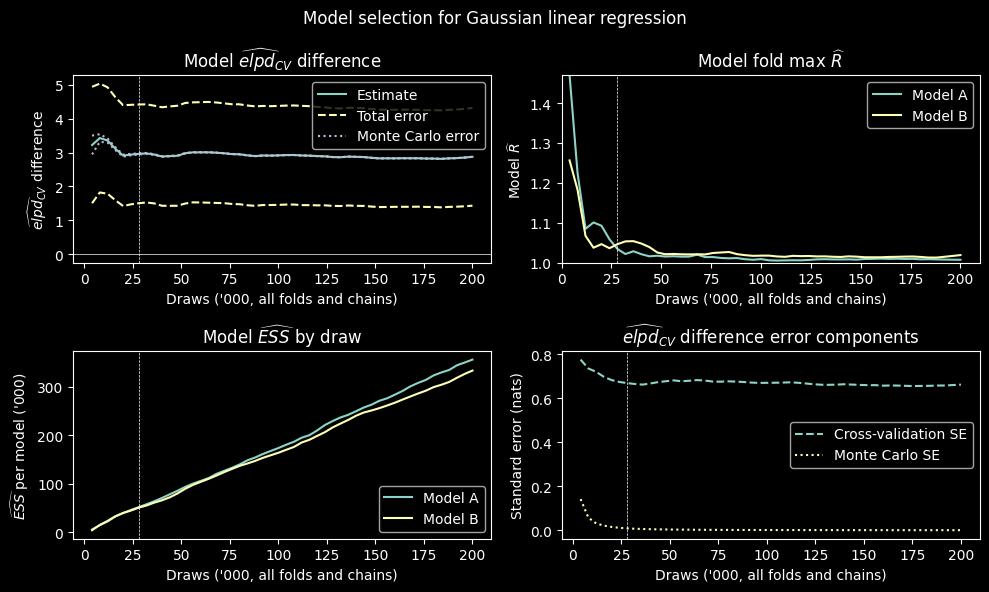

In [4]:
plot_model_results(results, title="Model selection for Gaussian linear regression")

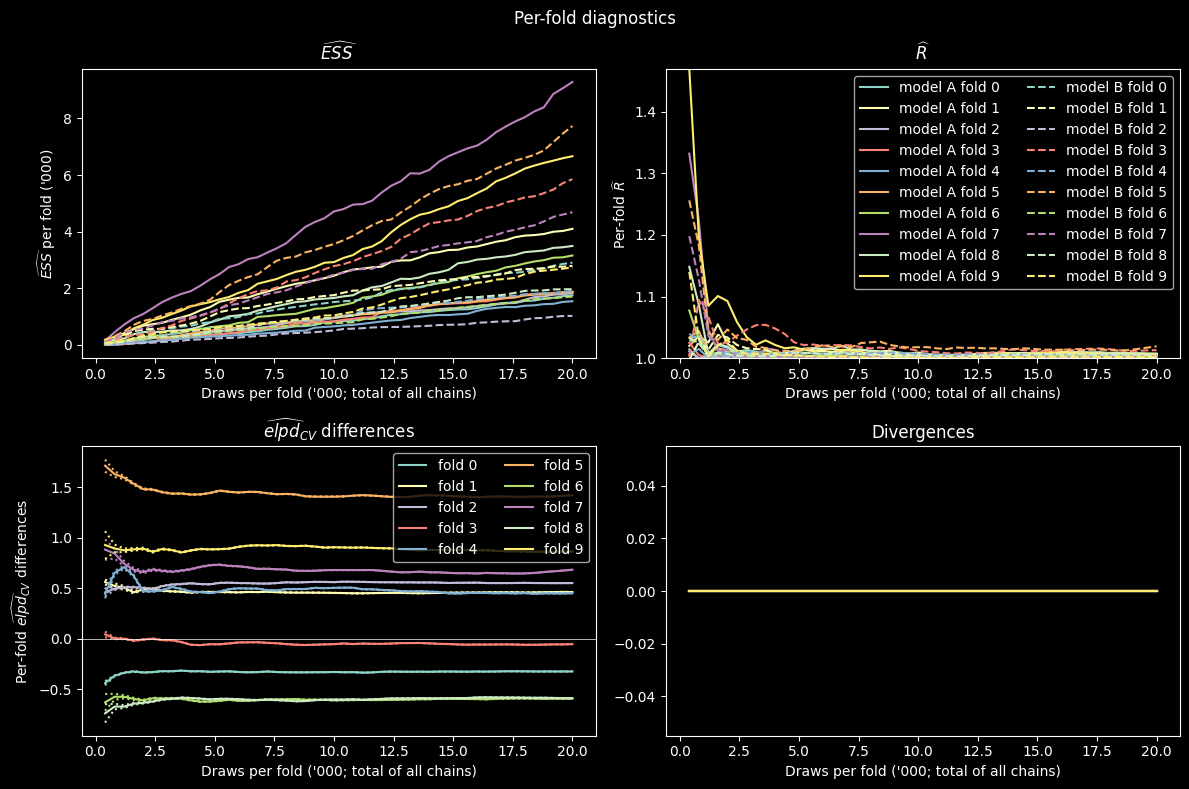

In [5]:
plot_fold_results(results, title='Per-fold diagnostics')